In [558]:
import lightgbm as lgb
import shap
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import xgboost as xgb
from xgboost.callback import TrainingCallback

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, f1_score, roc_auc_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import numpy as np

In [1297]:
df = pd.read_csv('/Users/anika/Desktop/BEM:EC 120/generated_datasets/wta_features_0425.csv')
df = df.dropna()
df = df[df['first_shot_loc'] != 'unknown']
df = df[df['first_serve_attempt'] != 'unknown']
df = df[df['serve_loc'] != 'unknown']

# If any values have a space in them, make it a _
df = df.replace(' ', '_', regex=True)

# make everything lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df = df[df['first_shot_loc'] != 'no_first_shot']

df['s+1'] = df['serve_loc'] + '_' + df['first_shot_loc']

In [1298]:
df.columns

Index(['match_id', 'server', 'opponent', 'hand_combo', 'surface',
       'game_advantage', 'set_advantage', 'point_advantage', 'pts_in_game',
       'pts_in_match', 'is_break_point', 'op_error_deuce_side_last20',
       'op_error_ad_side_last20', 'op_error_middle_last20',
       's1_success_rate_whole_match', 'wide_returner_win_recent_matches',
       'body_returner_win_recent_matches', 'wide_server_win_rate',
       'body_server_win_rate', 'T_server_win_rate',
       'T_returner_win_recent_matches', 'returner_win_1st/2nd_recent_matches',
       's1_success_recent_matches', 'court_side', 'first_serve_attempt',
       'serve_loc', 'first_shot_loc', 'won_pt', 'is_forced_err',
       'rally_category', 'rally_length', 's1_success', 'data_split', 's+1'],
      dtype='object')

In [1299]:
def combo_score(won_pt, rally_length, decay=0.15):
    if not won_pt:
        return 0.0
    return np.exp(-decay * rally_length)

In [1300]:
def preprocess_data(df):

    df = df.copy()
    # Columns to one-hot encode
    one_hot_cols = [
        'surface', 'hand_combo', 'court_side', 'first_serve_attempt',
        'serve_loc', 'first_shot_loc', 'is_break_point', 's+1'
    ]

    # Label encode server and opponent (for embeddings)
    label_encoders = {}
    for col in ['server', 'opponent']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=one_hot_cols)

    df['interaction_returns_wide'] = df['serve_loc_wide'] * df['wide_returner_win_recent_matches']
    df['interaction_returns_body'] = df['serve_loc_body'] * df['body_returner_win_recent_matches']
    df['interaction_returns_T'] = df['serve_loc_t'] * df['T_returner_win_recent_matches']

    df['interaction_+1_deuce'] = df['first_shot_loc_deuce_court'] * df['op_error_deuce_side_last20']
    df['interaction_+1_ad'] = df['first_shot_loc_ad_court'] * df['op_error_ad_side_last20']
    df['interaction_+1_middle'] = df['first_shot_loc_middle'] * df['op_error_middle_last20']

    df['interaction_serve_wide'] = df['serve_loc_wide'] * df['wide_server_win_rate']
    df['interaction_serve_body'] = df['serve_loc_body'] * df['body_server_win_rate']
    df['interaction_serve_T'] = df['serve_loc_t'] * df['T_server_win_rate']

    return df, label_encoders

In [1301]:
def eval_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_label = (y_pred >= 0.5).astype(int)
    f1 = f1_score(y, y_pred_label)
    accuracy = accuracy_score(y, y_pred_label)
    return f1, accuracy

def train_and_eval_model(X_train, X_val, y_train, y_val, scaled = True, class_imbalance = True):
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)
    scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
    sample_weights = np.where(y_train == 1, scale_weight, 1.0)
    if scaled:
        train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weights)

    params = {
        'objective': 'binary',
        'metric': ['binary_logloss','f1'],
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'verbose': -1,
        'is_unbalance': class_imbalance
        # 'num_leaves': 63,        # try higher
        # 'metric': ['binary_logloss','f1'],
        # 'min_data_in_leaf': 10,
        # 'max_depth': 10,         # try shallower or deeper
        # 'learning_rate': 0.05,
        # 'feature_fraction': 0.9, # sub-sample features
        # 'bagging_fraction': 0.8, # sub-sample data
        # 'bagging_freq': 5,    
        # 'is_unbalance': class_imbalance  
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],  # Track metrics on both training and validation sets
        valid_names=['train', 'valid'],      # Names for datasets in logs
        num_boost_round=100,                 # Number of boosting rounds
        # callbacks=[lgb.log_evaluation(50)]
    )

    X_val_first_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 1]
    y_val_first_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 1]

    X_val_second_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 0]
    y_val_second_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 0]

    f1_1, accuracy_1 = eval_model(model, X_val_first_serve, y_val_first_serve)
    # print('--- First Serve ---')
    # print("F1:", f1_1)
    # print(f"Accuracy: {accuracy_1}")

    f1_2, accuracy_2 = eval_model(model, X_val_second_serve, y_val_second_serve)
    # print('--- Second Serve ---')
    # print("F1:", f1_2)
    # print(f"Accuracy: {accuracy_2}")

    f1, accuracy = eval_model(model, X_val, y_val)
    # print('--- Overall Serve ---')
    # print("F1:", f1)
    # print(f"Accuracy: {accuracy}")

    return model, (f1, accuracy), (f1_1, accuracy_1), (f1_2, accuracy_2)

In [1302]:
def train_and_eval_model_xgb(X_train, X_val, y_train, y_val, scaled=True, class_imbalance=True):
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if class_imbalance else 1.0

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    params = {
        # 'objective': 'binary:logistic',
        # 'eval_metric': ['logloss'],
        # 'learning_rate': 0.05,
        # 'max_depth': 6,
        # # 'scale_pos_weight': scale_pos_weight,
        # 'verbosity': 0,
        'objective': 'binary:logistic',   # You want probability outputs
        'eval_metric': 'logloss',          # Good to use logloss; can add 'auc' or custom F1 later
        'learning_rate': 0.03,             # 🔵 Slower learning = more stable (especially with noise)
        'max_depth': 3,                    # 🔵 Shallower trees to reduce overfitting (try 4-6)
        'min_child_weight': 20,            # 🔵 Force minimum samples per leaf → smoother trees
        'subsample': 0.8,                  # 🔵 Row sampling → regularization
        'colsample_bytree': 0.8,           # 🔵 Feature sampling → regularization
        'lambda': 5.0,                     # 🔵 L2 regularization (default 1) — stabilizes leaf weights
        'alpha': 1.0,                      # 🔵 L1 regularization (can tune later)
        'verbosity': 0,                    # 🔵 Silent mode
    }

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=watchlist,
        verbose_eval=50,
        early_stopping_rounds=50
    )

    # Evaluate separately for first and second serves
    X_val_first_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 1]
    y_val_first_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 1]

    X_val_second_serve = X_val[X_val['first_serve_attempt_made_first_serve'] == 0]
    y_val_second_serve = y_val[X_val['first_serve_attempt_made_first_serve'] == 0]

    f1_1, accuracy_1 = eval_model(model, xgb.DMatrix(X_val_first_serve), y_val_first_serve)
    f1_2, accuracy_2 = eval_model(model, xgb.DMatrix(X_val_second_serve), y_val_second_serve)
    f1, accuracy = eval_model(model, dvalid, y_val)

    return model, (f1, accuracy), (f1_1, accuracy_1), (f1_2, accuracy_2)

In [1303]:
def model_results(df_preprocessed, player, feature_cols, target_cols, type, results = None): 
    df_train = df_preprocessed[df_preprocessed['data_split'] == 'train'].drop('data_split', axis=1)
    df_test = df_preprocessed[df_preprocessed['data_split'] == 'test'].drop('data_split', axis=1)
    X_train, X_val = df_train[feature_cols], df_test[feature_cols]
    y_train, y_val = df_train[target_cols].astype(float), df_test[target_cols].astype(float)
    y_train = y_train.squeeze()
    y_val = y_val.squeeze()

    # model, total, fs, ss = train_and_eval_model_xgb(X_train, X_val, y_train, y_val, True, False)
    # results[player][type]['scaled'] = [total, fs, ss]

    model, total, fs, ss = train_and_eval_model_xgb(X_train, X_val, y_train, y_val, False, True)
    results[player][type]['class_imbalance'] = [total, fs, ss]

    # model, total, fs, ss = train_and_eval_model_xgb(X_train, X_val, y_train, y_val, False, False)
    # results[player][type]['no_imbalance_fix'] = [total, fs, ss]
    return model, X_val, y_val

In [1304]:
def find_players_many_points(df):
    # Count the number of players in df['server'] who have > 1500 points with df['data_split'] == 'train' and > 100 in df['data_split'] == 'test'
    df_res = df.groupby('server').filter(lambda x: (x['data_split'] == 'train').sum() > 1500 and (x['data_split'] == 'test').sum() > 200)
    return df_res['server'].unique()

In [1305]:
players_lst = find_players_many_points(df)
players_lst

array(['elina_svitolina', 'caroline_wozniacki', 'angelique_kerber',
       'victoria_azarenka', 'maria_sakkari', 'jessica_pegula',
       'daria_kasatkina', 'naomi_osaka', 'bianca_andreescu',
       'sofia_kenin', 'iga_swiatek', 'ons_jabeur', 'karolina_muchova',
       'arantxa_rus', 'coco_gauff', 'elena_rybakina'], dtype=object)

In [1307]:
results = defaultdict(lambda : defaultdict(lambda: defaultdict(list))) # defaultdict

In [1308]:
for player in players_lst:
    df_player = df[(df['server'] == player)]
    assert len(df_player) > 1000

    print(len(df_player[df_player['data_split'] == 'train']), len(df_player[df_player['data_split'] == 'test']), len(df_player[df_player['data_split'] == 'fine_tune']))

    df_preprocessed, label_encoders = preprocess_data(df_player)

    # categorical_cols = ['server', 'opponent']
    categorical_cols = []

    # After one-hot encoding, collect all new columns
    one_hot_prefixes_basic = ['s+1_']
    one_hot_prefixes_complex = ['s+1_']

    numerical_cols_basic = [col for col in df_preprocessed.columns if any(col.startswith(prefix) for prefix in one_hot_prefixes_basic)] + [
        'first_serve_attempt_made_first_serve', 'court_side_deuce'
    ]

    numerical_cols_complex = [col for col in df_preprocessed.columns if any(col.startswith(prefix) for prefix in one_hot_prefixes_complex)] + [
        'first_serve_attempt_made_first_serve',
        'is_break_point_True',
        # 'point_advantage',
        # 'wide_returner_win_recent_matches', 'body_returner_win_recent_matches',
        # 'T_returner_win_recent_matches',
        'returner_win_1st/2nd_recent_matches',
        # 's1_success_recent_matches',
        # 'op_error_deuce_side_last20', 'op_error_ad_side_last20',
        # 'op_error_middle_last20',
        # 's1_success_rate_whole_match',
        'interaction_returns_wide', 'interaction_returns_body', 'interaction_returns_T',
        'interaction_+1_deuce', 'interaction_+1_ad', 'interaction_+1_middle',
        'interaction_serve_wide', 'interaction_serve_body', 'interaction_serve_T'
    ]

    # target_cols = ['s1_success']
    target_cols = ['won_pt']

    feature_cols_basic = categorical_cols + numerical_cols_basic
    feature_cols_complex = categorical_cols + numerical_cols_complex

    print('Basic -----')
    basic_model, basic_X, basic_y = model_results(df_preprocessed, player, feature_cols_basic, target_cols, 'basic', results)
    print('Complex -----')
    complex_model, complex_X, complex_y = model_results(df_preprocessed, player, feature_cols_complex, target_cols, 'complex', results)

4526 429 0
Basic -----
[0]	train-logloss:0.69272	valid-logloss:0.69229
[50]	train-logloss:0.68582	valid-logloss:0.68467
[100]	train-logloss:0.68429	valid-logloss:0.68430
[150]	train-logloss:0.68379	valid-logloss:0.68453
[171]	train-logloss:0.68367	valid-logloss:0.68482
Complex -----
[0]	train-logloss:0.69269	valid-logloss:0.69241
[50]	train-logloss:0.68272	valid-logloss:0.68756
[100]	train-logloss:0.67879	valid-logloss:0.68645
[150]	train-logloss:0.67556	valid-logloss:0.68537
[199]	train-logloss:0.67256	valid-logloss:0.68565
3302 534 0
Basic -----
[0]	train-logloss:0.69210	valid-logloss:0.68995
[50]	train-logloss:0.68561	valid-logloss:0.68870
[77]	train-logloss:0.68437	valid-logloss:0.68928
Complex -----
[0]	train-logloss:0.69196	valid-logloss:0.69007
[50]	train-logloss:0.67928	valid-logloss:0.69187
[63]	train-logloss:0.67761	valid-logloss:0.69263
2687 454 0
Basic -----
[0]	train-logloss:0.69211	valid-logloss:0.69360
[50]	train-logloss:0.68753	valid-logloss:0.68810
[100]	train-logloss:

In [1310]:
def compare_results(results, model_type):
    f1_lift_scaled, acc_lift_scaled = [], []
    f1_lift_scaled_fs, acc_lift_scaled_fs = [], []
    f1_lift_scaled_ss, acc_lift_scaled_ss = [], []

    all_complex_f1, all_complex_acc = [], []
    all_complex_f1_fs, all_complex_acc_fs = [], []
    all_complex_f1_ss, all_complex_acc_ss = [], []
    
    for player in results.keys():
        player_res = results[player]
        basic_f1, basic_acc = player_res['basic'][model_type][0]
        basic_f1_fs, basic_acc_fs = player_res['basic'][model_type][1]
        basic_f1_ss, basic_acc_ss = player_res['basic'][model_type][2]

        complex_f1, complex_acc = player_res['complex'][model_type][0]
        complex_f1_fs, complex_acc_fs = player_res['complex'][model_type][1]
        complex_f1_ss, complex_acc_ss = player_res['complex'][model_type][2]

        f1_lift_scaled.append(complex_f1 - basic_f1)
        acc_lift_scaled.append(complex_acc - basic_acc)

        f1_lift_scaled_fs.append(complex_f1_fs - basic_f1_fs)
        acc_lift_scaled_fs.append(complex_acc_fs - basic_acc_fs)

        f1_lift_scaled_ss.append(complex_f1_ss - basic_f1_ss)
        acc_lift_scaled_ss.append(complex_acc_ss - basic_acc_ss)

        all_complex_f1.append(complex_f1)
        all_complex_acc.append(complex_acc)

        all_complex_f1_fs.append(complex_f1_fs)
        all_complex_acc_fs.append(complex_acc_fs)

        all_complex_f1_ss.append(complex_f1_ss)
        all_complex_acc_ss.append(complex_acc_ss)


    print(f'Overall Lift in (F1, Accuracy): {np.mean(f1_lift_scaled), np.mean(acc_lift_scaled)}')
    print(f'First Serve Lift in (F1, Accuracy): {np.mean(f1_lift_scaled_fs), np.mean(acc_lift_scaled_fs)}')
    print(f'Second Serve Lift in (F1, Accuracy): {np.mean(f1_lift_scaled_ss), np.mean(acc_lift_scaled_ss)}')

    print(f'Overall (F1, Accuracy): {np.mean(all_complex_f1), np.mean(all_complex_acc)}')
    print(f'First Serve (F1, Accuracy): {np.mean(all_complex_f1_fs), np.mean(all_complex_acc_fs)}')
    print(f'Second Serve (F1, Accuracy): {np.mean(all_complex_f1_ss), np.mean(all_complex_acc_ss)}')

    print(f1_lift_scaled, acc_lift_scaled)
    print(f1_lift_scaled_fs, acc_lift_scaled_fs)
    print(f1_lift_scaled_ss, acc_lift_scaled_ss)


In [1311]:
compare_results(results, 'class_imbalance')

Overall Lift in (F1, Accuracy): (0.004812459847743884, 0.002637168749689594)
First Serve Lift in (F1, Accuracy): (-0.01143910317266307, -0.0012923389435572676)
Second Serve Lift in (F1, Accuracy): (0.09456759569309547, 0.011209414656696465)
Overall (F1, Accuracy): (0.5641082665655697, 0.549948252691562)
First Serve (F1, Accuracy): (0.6205776369359286, 0.5547470067804989)
Second Serve (F1, Accuracy): (0.4228859631954018, 0.544255035381719)
[-0.009279609279609247, 0.08678160919540234, 0.019739476597649075, -0.011598081855692999, 0.004219850735858344, -0.06755271220039649, -0.030989746808955887, -0.008479299363057247, 0.008568187000200567, -0.023621828293361125, -0.005623833891762797, -0.04047976011993998, 0.026465600775193887, 0.13593678494065964, -0.010589410589410542, 0.0035021307211245967] [0.002331002331002363, 0.01872659176029967, -0.028634361233480177, -0.02990033222591365, 0.01724137931034475, -0.020342612419700257, 0.01449275362318836, 0.0, -0.011508951406649648, -0.0061475409836

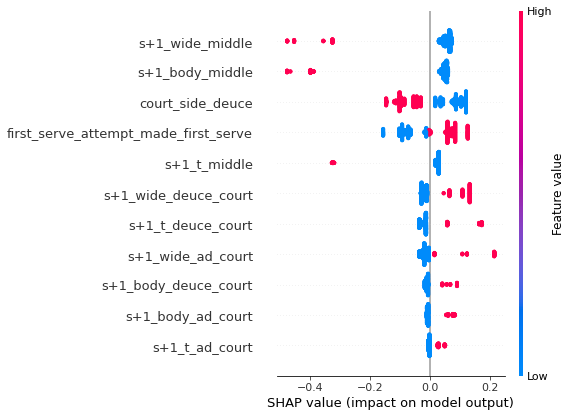

In [1230]:
# --- Step 6: SHAP Analysis ---
explainer = shap.TreeExplainer(basic_model)
shap_values = explainer.shap_values(basic_X)
shap.summary_plot(shap_values, basic_X) # Class 1 = s1_success

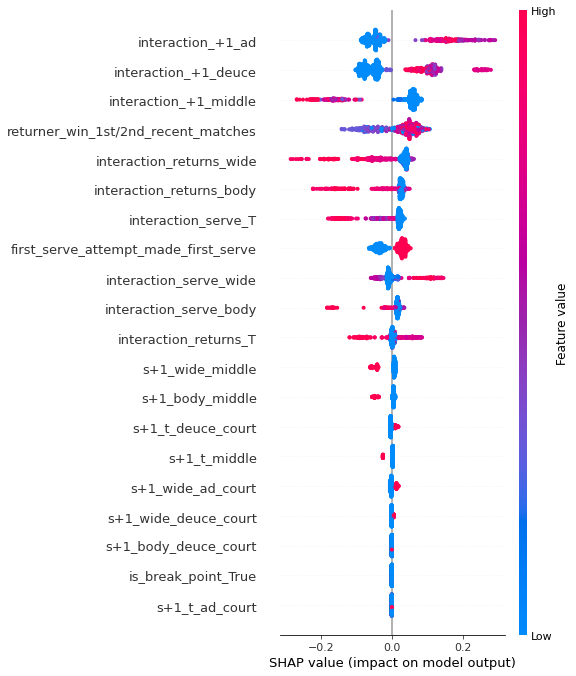

In [1231]:
# --- Step 6: SHAP Analysis ---
explainer = shap.TreeExplainer(complex_model)
shap_values = explainer.shap_values(complex_X)
shap.summary_plot(shap_values, complex_X) # Class 1 = s1_success

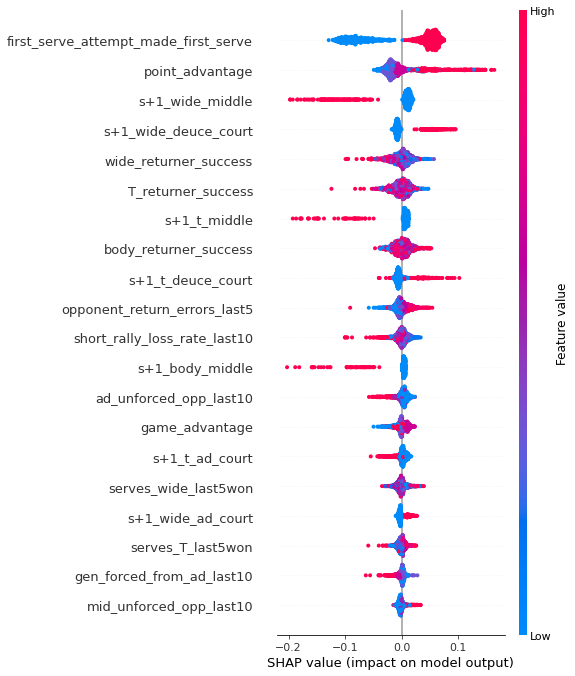

In [248]:
# --- Step 6: SHAP Analysis ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)  # Class 1 = s1_success